DECISION TREE !!!!

These are used for both classification and regression tasks. It creates a tree-like structure by splitting the dataset into subsets based on feature values, they do not require feature scaling but can easily be prone to overfitting if the depth is not controlled.

SCRATCH IMPLEMENTATION on Iris DATASET !! (Classification task)

Training Accuracy: 0.9583333333333334
Test Accuracy: 1.0


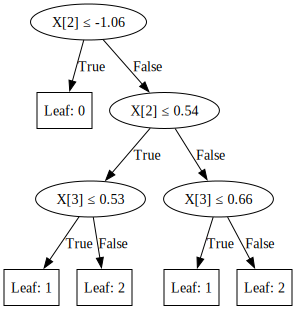

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from graphviz import Digraph


def gini(y):
    classes = np.unique(y)
    impurity = 1.0
    for cls in classes:
        p = np.sum(y == cls) / len(y)
        impurity -= p ** 2
    return impurity

def best_split(X, y):
    best_feature, best_threshold, best_gini = None, None, 1.0
    n_samples, n_features = X.shape

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left = y[X[:, feature] <= threshold]
            right = y[X[:, feature] > threshold]

            if len(right) == 0 or len(left) ==0:
                continue

            gini_left = gini(left)
            gini_right = gini(right)
            weighted_gini = (len(right) * gini(right) + len(left) * gini(left)) / len(y)

            if weighted_gini < best_gini:
             best_gini = weighted_gini
             best_feature = feature
             best_threshold = threshold

    return best_feature , best_threshold

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def build_tree(X,y, depth = 0, max_depth = 5):
    if len(set(y)) == 1 or depth >= max_depth:
        most_common = np.bincount(y).argmax()
        return Node(value = most_common)

    feature, threshold = best_split(X, y)
    if feature is None:
        most_common = np.bincount(y).argmax()
        return Node(value = most_common)

    left_indices = X[:, feature] <= threshold
    right_indices = X[:,feature] > threshold

    left_subtree = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth = 3)
    right_subtree = build_tree(X[right_indices], y[right_indices], depth + 1, max_depth = 3)

    return Node(feature, threshold, left_subtree, right_subtree)

def predict(sample, tree):
    if tree.value is not None:
        return tree.value
    if sample[tree.feature] <= tree.threshold:
        return predict(sample, tree.left)
    else:
        return predict(sample, tree.right)

def predict_all(X, tree):
    return np.array([predict(sample, tree) for sample in X])

df = pd.read_csv("../data/Iris.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

le = LabelEncoder()
y = le.fit_transform(y)

X = (X - X.mean(axis=0)) / X.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = build_tree(X_train, y_train, max_depth=3)

train_preds = predict_all(X_train, tree)
test_preds = predict_all(X_test, tree)

train_acc = np.mean(train_preds == y_train)
test_acc = np.mean(test_preds == y_test)

print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

def visualize_tree(node, dot=None, counter=[0]):
    if dot is None:
        dot = Digraph()
    
    node_id = str(counter[0])
    counter[0] += 1

    if node.value is not None:
        dot.node(node_id, f"Leaf: {node.value}", shape="box")
        return dot, node_id

    dot.node(node_id, f"X[{node.feature}] ≤ {round(node.threshold, 2)}")

    dot, left_id = visualize_tree(node.left, dot, counter)
    dot.edge(node_id, left_id, label="True")

    dot, right_id = visualize_tree(node.right, dot, counter)
    dot.edge(node_id, right_id, label="False")

    return dot, node_id

dot, _ = visualize_tree(tree)
dot 

Using SCIKIT-LEARN !! (less stressful huh...)

Training accuracy:  0.8137082601054482
Test accuracy:  0.7622377622377622


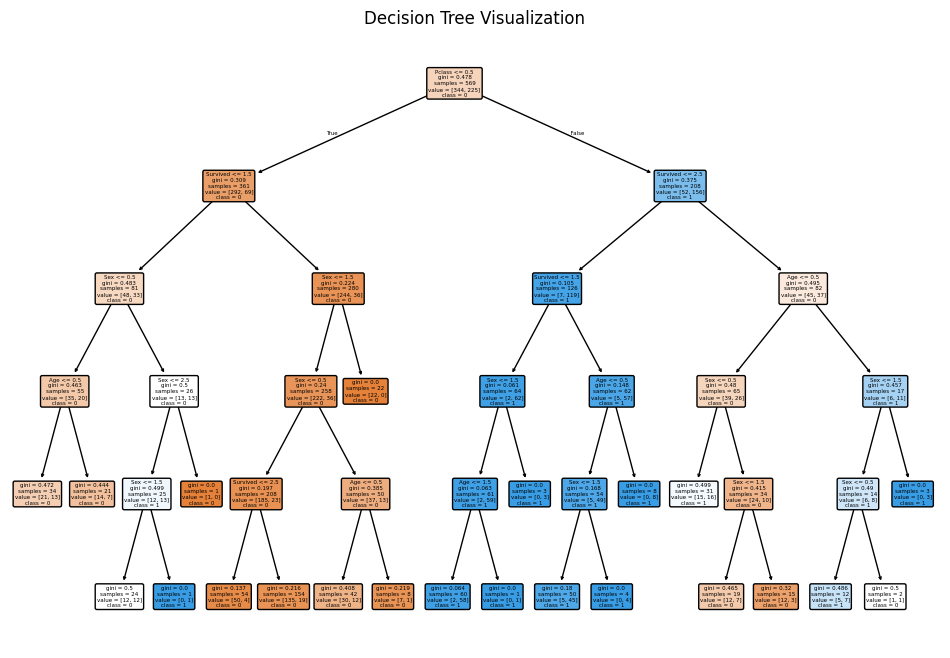

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#df = pd.read_csv("../data/Iris.csv")                 training accuracy: 0.9916666666666667
#X = df.iloc[:, :-1].values                           test accuracy: 1.0
#y = df.iloc[:, -1].values

df = pd.read_csv("../data/Titanic-Dataset.csv")                                              # decent train and test scores
df = df[['Survived', 'Pclass', 'Sex', 'Age','SibSp', 'Fare', 'Embarked']].dropna()

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
X = df[['Pclass', 'Sex', 'SibSp', 'Embarked']]
y = df['Survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train,y_train)

train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, clf.predict(X_test))
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

plt.figure(figsize=(12, 8))
plot_tree(clf, 
          feature_names=df.columns[:-1], 
          class_names=[str(cls) for cls in clf.classes_], 
          filled=True, 
          rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

Decision tree on Regression problem ( same as classification but evaluation metrics and split criterion differs)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


def calculate_mse(y):
    if len(y) == 0:
        return 0
    return np.mean((y-np.mean(y)) ** 2)

def best_split(X, y):
    best_feature, best_threshold, best_mse = None, None, calculate_mse(y)
    n_samples, n_features = X.shape

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left = y[X[:, feature] <= threshold]
            right = y[X[:, feature] > threshold]

            if len(right) == 0 or len(left) ==0:
                continue

            mse_left = calculate_mse(left)
            mse_right = calculate_mse(right)
            weighted_mse = (len(right) * calculate_mse(right) + len(left) * calculate_mse(left)) / len(y)


            if weighted_mse < best_mse:
             best_mse = weighted_mse
             best_feature = feature
             best_threshold = threshold

    return best_feature , best_threshold

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def build_tree(X,y, depth = 0, max_depth = 5, min_sample_split = 1):
    if len(y) < min_sample_split or depth >= max_depth or len(np.unique(y)) == 1:
        return Node(value = np.mean(y))

    feature, threshold = best_split(X, y)
    if feature is None:
        return Node(value = np.mean(y))

    left_indices = X[:, feature] <= threshold
    right_indices = X[:,feature] > threshold

    left_subtree = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth = 3)
    right_subtree = build_tree(X[right_indices], y[right_indices], depth + 1, max_depth = 3)

    return Node(feature, threshold, left_subtree, right_subtree)

def predict(sample, tree):
    if tree.value is not None:
        return tree.value
    if sample[tree.feature] <= tree.threshold:
        return predict(sample, tree.left)
    else:
        return predict(sample, tree.right)

def predict_all(X, tree):
    return np.array([predict(sample, tree) for sample in X])

df = pd.read_csv("../data/HousingData.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = build_tree(X_train, y_train, max_depth=3)

train_preds = predict_all(X_train, tree)
test_preds = predict_all(X_test, tree)


train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train R² Score:", round(train_r2 * 100, 2), "%")
print("Test R² Score:", round(test_r2 * 100, 2), "%")


Train MSE: 20.448302394699596
Test MSE: 14.9633165090633
Train R² Score: 76.46 %
Test R² Score: 79.6 %


Train mse: , 11.57
Test mse: , 12.35
Train r2 score: , 90.47% 
Test r2 score: , 72.42% 


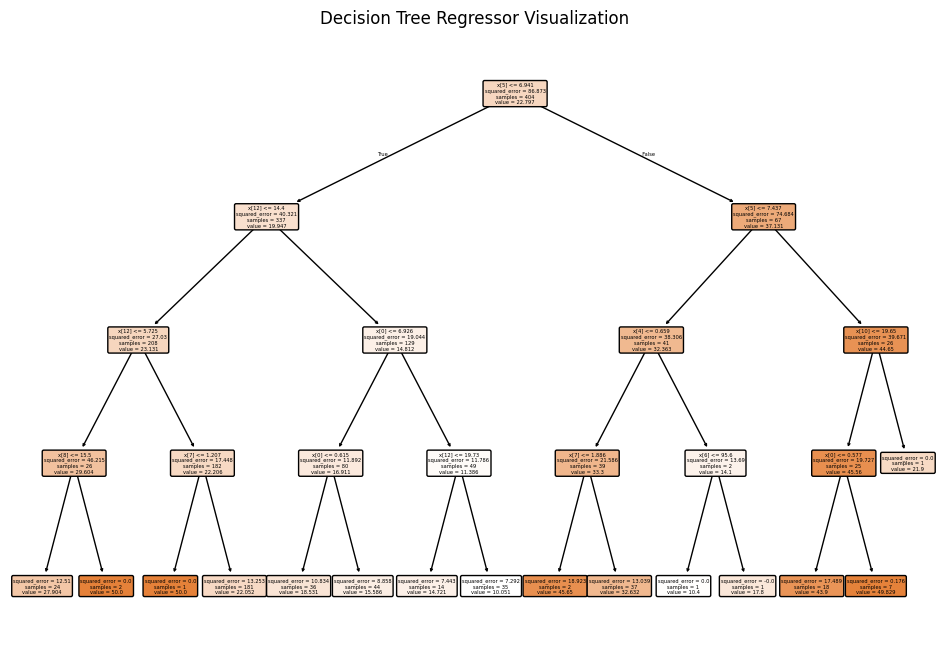

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt 

df = pd.read_csv("../data/HousingData.csv")
X = df.iloc[: , :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(max_depth=4, random_state=42)
model.fit(X_train, y_train)

train_mse = mean_squared_error(y_train, model.predict(X_train))
test_mse = mean_squared_error(y_test, model.predict(X_test))
train_r2 = r2_score(y_train, model.predict(X_train))
test_r2 = r2_score(y_test, model.predict(X_test))

print(f"Train mse: , {train_mse:.2f}")
print(f"Test mse: , {test_mse:.2f}")
print(f"Train r2 score: , {train_acc * 100:.2f}% ")
print(f"Test r2 score: , {test_acc * 100:.2f}% ")

plt.figure(figsize=(12, 8))
plot_tree(model, 
          filled=True, 
          rounded=True)
plt.title("Decision Tree Regressor Visualization")
plt.show()


While the training performance is strong, the drop in test accuracy suggests that the model may be overfitting to the training data and not generalizing well to unseen samples. To improve this, we have to try ensemble methods like Random Forest or Gradient Boosting. (see the respective notebooks!)